In [1]:
import numpy as np
import time
import torch
import random
import sys
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn, optim, autograd
from scipy.integrate import odeint

from google.colab import drive
drive.mount("/content/drive")

main_path = "/content/drive/My Drive/Workspace/Fourier_PINN/" # ENZE marked: you need to change your main_path if it's not here
sys.path.append(main_path)

from utils import draw_two_dimension, MultiSubplotDraw

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
class Parameters:
    beta = 0.01
    gamma = 0.05
    N = 100.0

class TrainArgs:
    iteration = 2000
    epoch_step = 100
    test_step = 500
    initial_lr = 0.001
    main_path = "/content/drive/My Drive/Workspace/Fourier_PINN/"


class Config:
    def __init__(self):
        self.model_name = "SIR_Fourier"
        self.curve_names = ["S", "I", "R"]
        self.params = Parameters
        self.args = TrainArgs
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.seed = 0

        self.T = 100
        self.T_unit = 1e-2
        self.T_N = int(self.T / self.T_unit)

        self.prob_dim = 3
        self.y0 = np.asarray([50.0, 49.0, 1.0])
        self.t = np.asarray([i * self.T_unit for i in range(self.T_N)])
        self.t_torch = torch.tensor(self.t, dtype=torch.float32).to(self.device)
        self.x = torch.tensor(np.asarray([[[i * self.T_unit] * self.prob_dim for i in range(self.T_N)]]), dtype=torch.float32).to(self.device)
        # print(self.x.shape)
        self.truth = odeint(self.pend, self.y0, self.t)

        self.modes = 64  # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.width = 16
        self.fc_map_dim = 128
    
    def pend(self, y, t):
        dydt = np.asarray([
            - self.params.beta * y[0] * y[1] ,
            self.params.beta * y[0] * y[1]  - self.params.gamma * y[1],
            self.params.gamma * y[1]
        ])
        return dydt


In [8]:
class SpectralConv1d(nn.Module):
    def __init__(self, config):
        super(SpectralConv1d, self).__init__()
        self.config = config
        self.in_channels = self.config.width
        self.out_channels = self.config.width
        self.scale = 1 / (self.in_channels * self.out_channels)
        self.weights = nn.Parameter(self.scale * torch.rand(self.in_channels, self.out_channels, self.config.modes, dtype=torch.cfloat))

    def compl_mul1d(self, input, weights):
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = torch.fft.rfft(x)
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1) // 2 + 1, dtype=torch.cfloat).to(self.config.device) 
        out_ft[:, :, :self.config.modes] = self.compl_mul1d(x_ft[:, :, :self.config.modes], self.weights)
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x


class FourierModel(nn.Module):
    def __init__(self, config):
        super(FourierModel, self).__init__()
        self.time_string = time.strftime("%Y%m%d_%H%M%S", time.localtime(time.time()))
        self.config = config
        self.setup_seed(self.config.seed)
        
        self.fc0 = nn.Linear(self.config.prob_dim, self.config.width)  # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.config)
        self.conv1 = SpectralConv1d(self.config)
        self.conv2 = SpectralConv1d(self.config)
        self.conv3 = SpectralConv1d(self.config)
        self.w0 = nn.Conv1d(self.config.width, self.config.width, 1)
        self.w1 = nn.Conv1d(self.config.width, self.config.width, 1)
        self.w2 = nn.Conv1d(self.config.width, self.config.width, 1)
        self.w3 = nn.Conv1d(self.config.width, self.config.width, 1)

        self.fc1 = nn.Linear(self.config.width, self.config.fc_map_dim)
        self.fc2 = nn.Linear(self.config.fc_map_dim, self.config.prob_dim)

        self.criterion = torch.nn.MSELoss("sum").to(self.config.device)

        self.y_tmp = None
        self.epoch_tmp = None
        self.loss_record_tmp = None

        self.figure_save_path_folder = "{0}/figure/{1}_{2}/".format(self.config.args.main_path, self.config.model_name, self.time_string)
        if not os.path.exists(self.figure_save_path_folder):
            os.makedirs(self.figure_save_path_folder)
        self.default_colors = ["red", "blue", "green", "pink", "cyan", "lime", "pink", "indigo", "brown", "grey"]

        print("using {}".format(str(self.config.device)))
        print("iteration = {}".format(self.config.args.iteration))
        print("epoch_step = {}".format(self.config.args.epoch_step))
        print("test_step = {}".format(self.config.args.test_step))
        print("model_name = {}".format(self.config.model_name))
        print("time_string = {}".format(self.time_string))
        self.truth_loss()


    def forward(self, x):
        # print("cp1", x.shape)
        x = self.fc0(x)
        # print("cp2", x.shape)
        x = x.permute(0, 2, 1)
        # print("cp3", x.shape)

        x1 = self.conv0(x)
        # print("cp4", x1.shape)
        x2 = self.w0(x)
        # print("cp5", x2.shape)
        x = x1 + x2
        x = F.gelu(x)
        # print("cp6", x.shape)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2
        # print("cp7", x.shape)
        x = x.permute(0, 2, 1)
        # print("cp8", x.shape)
        x = self.fc1(x)
        # print("cp9", x.shape)
        x = F.gelu(x)
        # print("cp10", x.shape)

        x = self.fc2(x)
        # print("cp11", x.shape)

        # print(x.shape)
        return x

    
    @staticmethod
    def setup_seed(seed):
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.deterministic = True
    """
    - self.params.beta * y[0] * y[1] / self.params.N,
    self.params.beta * y[0] * y[1] / self.params.N - self.params.gamma * y[1],
    self.params.gamma * y[1]
    """
    def ode_gradient(self, x, y):
        S = y[0, :, 0]
        I = y[0, :, 1]
        R = y[0, :, 2]
        S_t = torch.gradient(S, spacing=(self.config.t_torch,))[0]
        I_t = torch.gradient(I, spacing=(self.config.t_torch,))[0]
        R_t = torch.gradient(R, spacing=(self.config.t_torch,))[0]
        f_S = S_t - (- self.config.params.beta * S * I )
        f_I = I_t - (self.config.params.beta * S * I  - self.config.params.gamma * I)
        f_R = R_t - (self.config.params.gamma * I)

        return f_S, f_I, f_R

    def loss(self, y):
        y0_pred = y[0, 0, :]
        y0_true = torch.tensor(self.config.y0, dtype=torch.float32).to(self.config.device)

        ode_1, ode_2, ode_3 = self.ode_gradient(self.config.x, y)
        zeros_1D = torch.zeros([self.config.T_N]).to(self.config.device)
        zeros_nD = torch.zeros([self.config.T_N, self.config.prob_dim]).to(self.config.device)

        loss1 = self.criterion(y0_pred, y0_true)
        loss2 = 10 * (self.criterion(ode_1, zeros_1D) + self.criterion(ode_2, zeros_1D) + self.criterion(ode_3, zeros_1D))
        loss3 = self.criterion(torch.abs(y - 0), y - 0) + self.criterion(torch.abs(self.config.params.N - y), self.config.params.N - y)
        loss4 = self.criterion(y[0, :, 0] + y[0, :, 1] + y[0, :, 2] - self.config.params.N, zeros_1D)
        # loss4 = self.criterion(1 / u_0, pt_all_zeros_3)
        # loss5 = self.criterion(torch.abs(u_0 - v_0), u_0 - v_0)

        loss = loss1 + loss2 + loss3 #+ loss4
        loss_list = [loss1, loss2, loss3]
        return loss, loss_list
    
    def truth_loss(self):
        y_truth = torch.tensor(self.config.truth.reshape([1, self.config.T_N ,self.config.prob_dim])).to(self.config.device)
        tl, tl_list = self.loss(y_truth)
        loss_print_part = " ".join(["Loss_{0:d}:{1:.8f}".format(i + 1, loss_part.item()) for i, loss_part in enumerate(tl_list)])
        print("Ground truth has loss: Loss:{0:.8f} {1}".format(tl.item(), loss_print_part))

    def train_model(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.config.args.initial_lr, weight_decay=0)
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda e: 1 / (e / 10000 + 1))
        self.train()

        start_time = time.time()
        start_time_0 = start_time
        loss_record = []
        
        for epoch in range(1, self.config.args.iteration + 1):
            optimizer.zero_grad()

            y = self.forward(self.config.x)
            loss, loss_list = self.loss(y)
            loss_record.append(loss.item())

            loss.backward()
            optimizer.step()
            scheduler.step()

            if epoch % self.config.args.epoch_step == 0:
                now_time = time.time()
                loss_print_part = " ".join(["Loss_{0:d}:{1:.6f}".format(i + 1, loss_part.item()) for i, loss_part in enumerate(loss_list)])
                print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} {3} Lr:{4:.6f} Time:{5:.6f}s ({6:.2f}min in total, {7:.2f}min remains)".format(epoch, self.config.args.iteration, loss.item(), loss_print_part, optimizer.param_groups[0]["lr"], now_time - start_time, (now_time - start_time_0) / 60.0, (now_time - start_time_0) / 60.0 / epoch * (self.config.args.iteration - epoch)))
                start_time = now_time

                if epoch % self.config.args.test_step == 0:
                    self.y_tmp = y
                    self.epoch_tmp = epoch
                    self.loss_record_tmp = loss_record
                    self.test_model()
    
    def test_model(self):
        y_draw = self.y_tmp[0].cpu().detach().numpy().swapaxes(0, 1)
        x_draw = self.config.t
        y_draw_truth = self.config.truth.swapaxes(0, 1)
        save_path = "{}/{}_{}_epoch={}.png".format(self.figure_save_path_folder, self.config.model_name, self.time_string, self.epoch_tmp)
        draw_two_dimension(
            y_lists=np.concatenate([y_draw, y_draw_truth], axis=0),
            x_list=x_draw,
            color_list=self.default_colors[: 2 * self.config.prob_dim],
            legend_list=self.config.curve_names + ["{}_true".format(item) for item in self.config.curve_names],
            line_style_list=["solid"] * self.config.prob_dim + ["dashed"] * self.config.prob_dim,
            fig_title="{}_{}_epoch={}".format(self.config.model_name, self.time_string, self.epoch_tmp),
            fig_size=(8, 6),
            show_flag=True,
            save_flag=True,
            save_path=save_path,
            save_dpi=300,
            legend_loc="center right",
        )
        print("Figure is saved to {}".format(save_path))
        self.draw_loss_multi(self.loss_record_tmp, [1.0, 0.5, 0.25])
    
    @staticmethod
    def draw_loss_multi(loss_list, last_rate_list):
        m = MultiSubplotDraw(row=1, col=len(last_rate_list), fig_size=(8 * len(last_rate_list), 6), tight_layout_flag=True, show_flag=True, save_flag=False, save_path=None)
        for one_rate in last_rate_list:
            # print(loss_list[-int(len(loss_list) * one_rate):])
            # print(range(len(loss_list) - int(len(loss_list) * one_rate) + 1, len(loss_list) + 1))
            m.add_subplot(
                y_lists=[loss_list[-int(len(loss_list) * one_rate):]],
                x_list=range(len(loss_list) - int(len(loss_list) * one_rate) + 1, len(loss_list) + 1),
                color_list=["blue"],
                line_style_list=["solid"],
                fig_title="Loss - lastest ${}$% - epoch ${}$ to ${}$".format(int(100 * one_rate), len(loss_list) - int(len(loss_list) * one_rate) + 1, len(loss_list)),
                fig_x_label="epoch",
                fig_y_label="loss")
        m.draw()




 


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


using cuda
iteration = 2000
epoch_step = 100
test_step = 500
model_name = SIR_Fourier
time_string = 20221019_231134
Ground truth has loss: Loss:0.00000036 Loss_1:0.00000000 Loss_2:0.00000036 Loss_3:0.00000000
Epoch [00100/02000] Loss:33.239838 Loss_1:1.133840 Loss_2:31.539036 Loss_3:0.566965 Lr:0.000990 Time:1.247085s (0.02min in total, 0.39min remains)
Epoch [00200/02000] Loss:8.092018 Loss_1:0.087281 Loss_2:7.838049 Loss_3:0.166689 Lr:0.000980 Time:1.212929s (0.04min in total, 0.37min remains)
Epoch [00300/02000] Loss:0.124410 Loss_1:0.000137 Loss_2:0.122658 Loss_3:0.001615 Lr:0.000971 Time:1.196566s (0.06min in total, 0.35min remains)
Epoch [00400/02000] Loss:0.022378 Loss_1:0.000082 Loss_2:0.022235 Loss_3:0.000061 Lr:0.000962 Time:1.253956s (0.08min in total, 0.33min remains)
Epoch [00500/02000] Loss:0.011780 Loss_1:0.000015 Loss_2:0.011759 Loss_3:0.000005 Lr:0.000952 Time:1.242067s (0.10min in total, 0.31min remains)


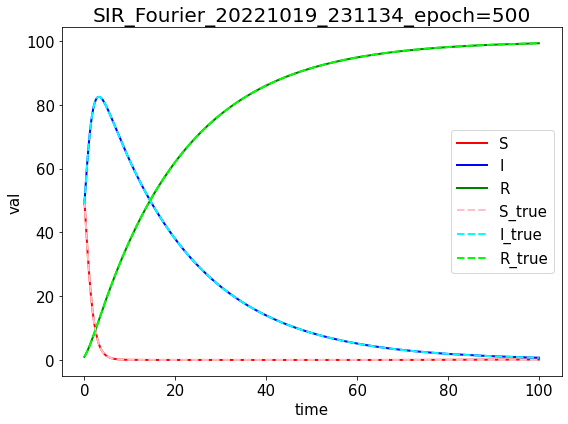

Figure is saved to /content/drive/My Drive/Workspace/Fourier_PINN//figure/SIR_Fourier_20221019_231134//SIR_Fourier_20221019_231134_epoch=500.png


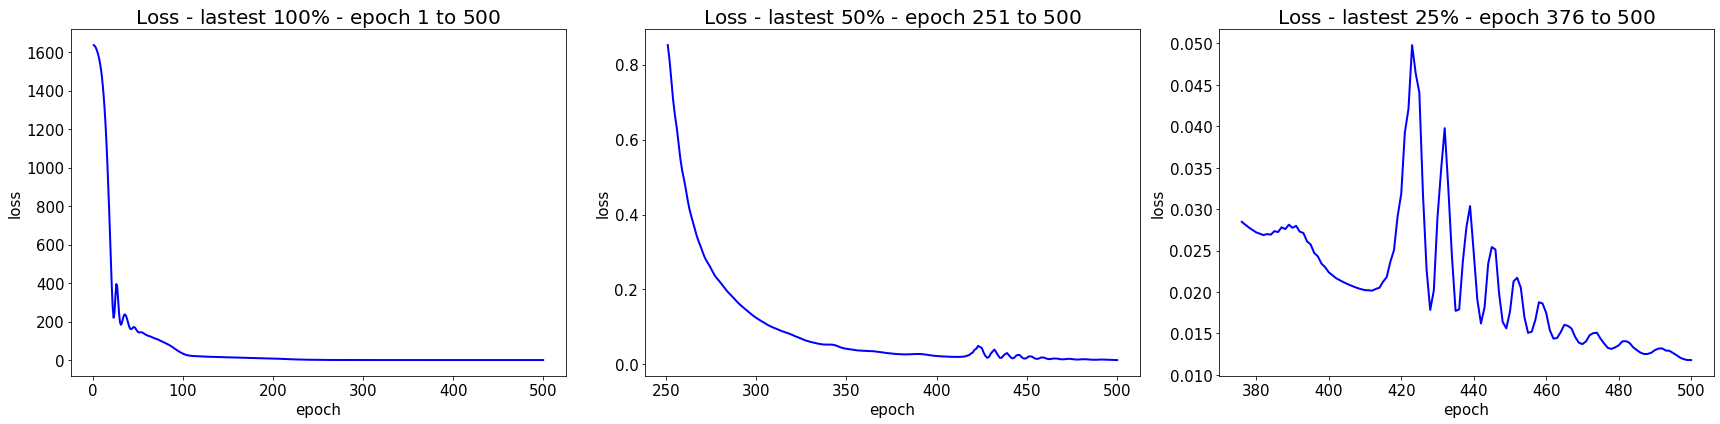

Epoch [00600/02000] Loss:0.007994 Loss_1:0.000044 Loss_2:0.007933 Loss_3:0.000017 Lr:0.000943 Time:2.583332s (0.15min in total, 0.34min remains)
Epoch [00700/02000] Loss:0.007420 Loss_1:0.000384 Loss_2:0.007036 Loss_3:0.000000 Lr:0.000935 Time:1.202596s (0.17min in total, 0.31min remains)
Epoch [00800/02000] Loss:0.004448 Loss_1:0.000001 Loss_2:0.004447 Loss_3:0.000000 Lr:0.000926 Time:1.223135s (0.19min in total, 0.28min remains)
Epoch [00900/02000] Loss:0.005922 Loss_1:0.000579 Loss_2:0.005342 Loss_3:0.000000 Lr:0.000917 Time:1.207646s (0.21min in total, 0.25min remains)
Epoch [01000/02000] Loss:0.003115 Loss_1:0.000000 Loss_2:0.003115 Loss_3:0.000000 Lr:0.000909 Time:1.205210s (0.23min in total, 0.23min remains)


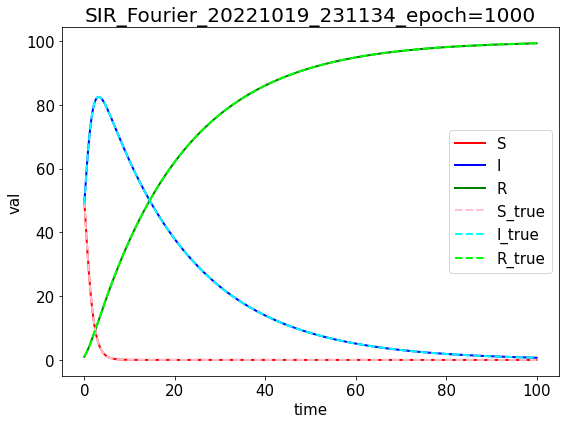

Figure is saved to /content/drive/My Drive/Workspace/Fourier_PINN//figure/SIR_Fourier_20221019_231134//SIR_Fourier_20221019_231134_epoch=1000.png


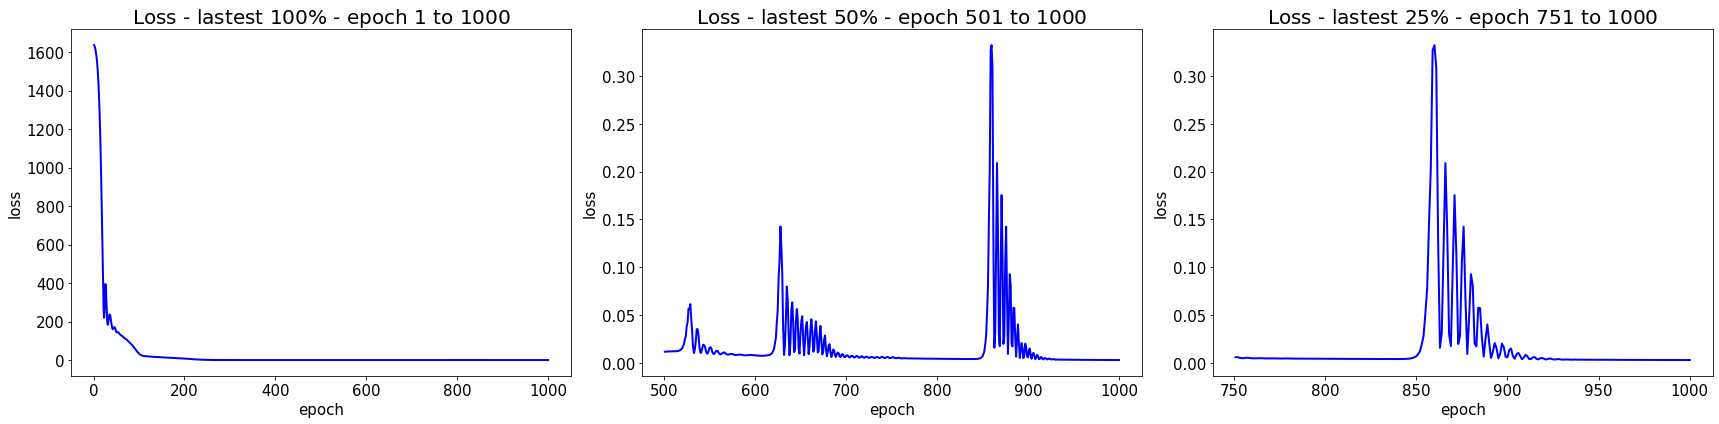

Epoch [01100/02000] Loss:0.002669 Loss_1:0.000000 Loss_2:0.002668 Loss_3:0.000000 Lr:0.000901 Time:2.631052s (0.27min in total, 0.22min remains)
Epoch [01200/02000] Loss:0.004398 Loss_1:0.000512 Loss_2:0.003824 Loss_3:0.000063 Lr:0.000893 Time:1.230352s (0.29min in total, 0.19min remains)
Epoch [01300/02000] Loss:0.002075 Loss_1:0.000000 Loss_2:0.002075 Loss_3:0.000000 Lr:0.000885 Time:1.225794s (0.31min in total, 0.17min remains)
Epoch [01400/02000] Loss:0.001836 Loss_1:0.000000 Loss_2:0.001836 Loss_3:0.000000 Lr:0.000877 Time:1.196111s (0.33min in total, 0.14min remains)
Epoch [01500/02000] Loss:0.006948 Loss_1:0.001790 Loss_2:0.005158 Loss_3:0.000000 Lr:0.000870 Time:1.217575s (0.35min in total, 0.12min remains)


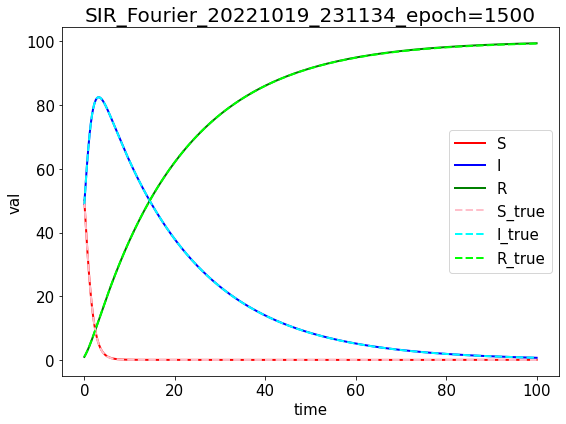

Figure is saved to /content/drive/My Drive/Workspace/Fourier_PINN//figure/SIR_Fourier_20221019_231134//SIR_Fourier_20221019_231134_epoch=1500.png


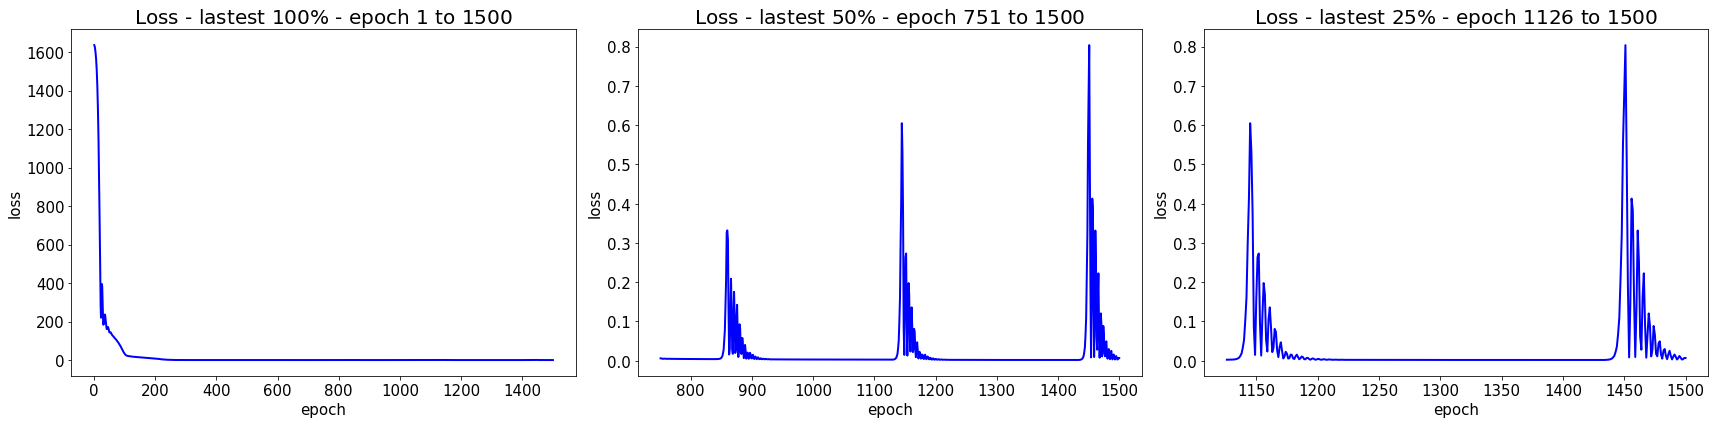

Epoch [01600/02000] Loss:0.001532 Loss_1:0.000000 Loss_2:0.001532 Loss_3:0.000000 Lr:0.000862 Time:2.612393s (0.39min in total, 0.10min remains)


KeyboardInterrupt: ignored

In [9]:
config = Config()
model = FourierModel(config).to(config.device)
model.train_model()